# A manifold for wall grasping

This notebook demonstrates how the pregrasp manifold for wall grasp works. To install the required libraries run:

```pip3 install transformations matplotlib numpy```

In [1]:
import transformations as tra
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [2]:
FIGURE_SIZE = (9, 9)

Uncomment this to plot in separate windows instead of the notebook. Requires pyqt5, install with `sudo apt-get install python3-pyqt5`.

In [3]:
# %matplotlib qt

In [4]:
# Decompose the frame into position, x direction, y direction, z direction
def decompose_frame(frame):
    return frame[:3, 3], frame[:3, 0], frame[:3, 1], frame[:3, 2]

# Plot a frame in a 3d axes
def plot_frame(ax, transformation, length, to_plot=[0, 1, 2]):
    axes = decompose_frame(transformation)
    colors = 'rgb'
    
    for i in to_plot:
        ax.quiver(axes[0][0], axes[0][1], axes[0][2], 
                  axes[i+1][0], axes[i+1][1], axes[i+1][2], 
                  color=colors[i], length=length)

# Plot a vector in a 2d axes
def plot_vector(ax, base, direction):
    ax.quiver(base[0], base[1], direction[0], direction[1])

The wall grasp manifold is constructed like this. Sampled poses are randomly translated along the Y axis of the initial frame.

After that, a rotation is done to orient the hand towards the object that will be wall grasped. The rotation is such that the -X axis of the sampled pose is in the direction towards the object centroid when they are projected on the surface plane. The calculations assume that the center frame is pointing at the object centroid in the same sense.

In [5]:
def sample_frame_on_manifold(center_frame, object_centroid, surface_frame, width):
    position, x, y, z = decompose_frame(center_frame)
    position_on_line = (np.random.random() - 0.5) * width
    
    sampled_frame = center_frame.dot(tra.translation_matrix([0, position_on_line, 0]))
    towards_centroid_in_surface_frame = surface_frame[:3, :3].T.dot(
        object_centroid[:3, 3] - sampled_frame[:3, 3])
    
    rotate_towards_centroid = np.pi + math.atan2(towards_centroid_in_surface_frame[1], 
                                               towards_centroid_in_surface_frame[0])
    
    z_surface_axis_in_sampled_frame = np.linalg.inv(sampled_frame[:3, :3]).dot(
        surface_frame[:3, 2])
    
    rotation_matrix = tra.quaternion_matrix(tra.quaternion_about_axis(angle=rotate_towards_centroid, 
                                                axis=z_surface_axis_in_sampled_frame))
    
    return sampled_frame.dot(rotation_matrix)

This demonstrates how the sampled frames look in 3d. The initial pregrasp frame is drawn in a larger size and with all three axes. The sampled frames are drawn in a smaller size and only with X and Z axes.

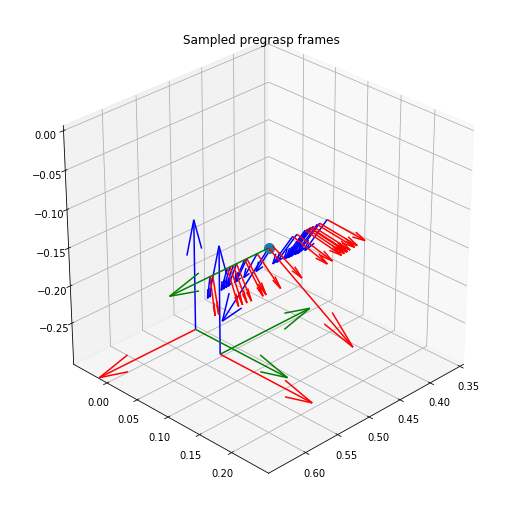

In [6]:
center_frame = tra.translation_matrix([0.5, 0.1, -0.15]).dot(
    tra.quaternion_matrix([ 0.1830127, 0.6830127, 0.6830127, -0.1830127]))
object_centroid = tra.translation_matrix([0.5, -0.02, -0.311]).dot(
    tra.quaternion_matrix([1, 0, 0, 0]))
surface_frame = tra.translation_matrix([0.48, 0, -0.346]).dot(
    tra.quaternion_matrix([0.7071055, 0.0, 0.0, 0.7071081]))

plane_radius = 0.2
center_frame_arrow_length = 0.15
sampled_frame_arrow_length = 0.05
scene_size = 0.3
samples = 20

fig2 = plt.figure(figsize=FIGURE_SIZE)
ax3d = fig2.add_subplot(111, projection='3d')
ax3d.set_xlim(center_frame[0, 3] - scene_size / 2, center_frame[0, 3] + scene_size / 2)
ax3d.set_ylim(center_frame[1, 3] - scene_size / 2, center_frame[1, 3] + scene_size / 2)
ax3d.set_zlim(center_frame[2, 3] - scene_size / 2, center_frame[2, 3] + scene_size / 2)

plot_frame(ax3d, center_frame, center_frame_arrow_length, to_plot=[0, 1, 2])
plot_frame(ax3d, object_centroid, center_frame_arrow_length, to_plot=[0, 1, 2])
plot_frame(ax3d, surface_frame, center_frame_arrow_length, to_plot=[0, 1, 2])

for i in range(samples):
    sampled_frame = sample_frame_on_manifold(center_frame, object_centroid, surface_frame, plane_radius)
    plot_frame(ax3d, sampled_frame, sampled_frame_arrow_length, to_plot=[0, 2])
ax3d.scatter(center_frame[0, 3], center_frame[1, 3], center_frame[2, 3], s=100)
ax3d.view_init(azim=45)
    
plt.title('Sampled pregrasp frames');